# Assignment 2
## Rom Amsili - 316509397
## Matan Leventer - 208447029

In [62]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 7.9 MB/s 


In [148]:
import numpy as np
import pandas as pd
import torch
import torchmetrics
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_classification
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import os
import cv2
from torchvision import transforms
from PIL import Image
from collections import defaultdict

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [147]:
train_data = open('Ass2_train.txt','r')
test_data = open('Ass2_train.txt','r')

In [149]:
def read_pic(name):
  """
  read pictures from path and convert them to tensor.
  name = picture name 
  """
  path = '/content/drive/MyDrive/lfw2'
  convert_tensor = transforms.ToTensor()
  transform = transforms.Resize(105)
  list_name = name[:-5]
  img = Image.open(os.path.join(path,list_name,(name+'.jpg')))
  return transform(convert_tensor(img))


In [150]:
path_train = 'Ass2_train.txt'
path_test = 'Ass2_test.txt'

In [ ]:
def txt_prep(path):
  list_pic = []
  with open(path) as f:
      lines = f.readlines()
      for line in lines[1:]:
        split_name = line.split("\t")
        if len(split_name) == 3 :
          number_1 = split_name[1]
          name_1 = split_name[0] +'_' + ((4-len(number_1)) * '0') + number_1
          number_2 = split_name[2].split('\n')[0]
          name_2 = split_name[0] +'_' + ((4-len(number_2)) * '0') + number_2
          list_pic.append(([read_pic(name_1),read_pic(name_2)],1))
        else : 
          number_1 = split_name[1]
          name_1 = split_name[0] +'_' + ((4-len(number_1)) * '0') + number_1
          number_2 = split_name[3].split('\n')[0]
          name_2 = split_name[2] +'_' + ((4-len(number_2)) * '0') + number_2
          list_pic.append(([read_pic(name_1),read_pic(name_2)],0))
  return list_pic

X_train =txt_prep(path_train)
X_test = txt_prep(path_test)

# Split Train and Validation sets

In [11]:
import random
X_val = []
for i in range(440):
  X_val.append(X_train.pop(random.randint(0,len(X_train)-1)))
len(X_val),len(X_train)

(440, 1760)

In [153]:
batch_size = 128  # 64 for Model B 

# Create data loaders.
train_dataloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(X_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=batch_size, shuffle = True)

In [154]:
class SiameseNet(nn.Module):
    def __init__(self,):
        super(SiameseNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, # model A - 64 out_channels
                               kernel_size=10, stride=(1,1))
        
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=(2,2))

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, # model A -128 out_channels
                               kernel_size=7, stride=(1,1))
        
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=(2,2))
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, # model A - 128 out_channels
                               kernel_size=4, stride=(1,1))
        
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=(2,2))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, #model A - 256 out_channels
                               kernel_size=4, stride=(1,1))
        
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(in_features=1152,out_features=4096) #model A - 9152 in_features

        self.fc2 = nn.Linear(in_features=4096,out_features=1)

        
        nn.init.normal_(self.conv1.weight,0,0.01)
        nn.init.normal_(self.conv1.bias,0.5,0.01)
        nn.init.normal_(self.conv2.weight,0,0.01)
        nn.init.normal_(self.conv2.bias,0.5,0.01)
        nn.init.normal_(self.conv3.weight,0,0.01)
        nn.init.normal_(self.conv3.bias,0.5,0.01)
        nn.init.normal_(self.conv4.weight,0,0.01)
        nn.init.normal_(self.conv4.bias,0.5,0.01)
        nn.init.normal_(self.fc1.weight,0,0.2)
        nn.init.normal_(self.fc1.bias,0.5,0.01)
        nn.init.normal_(self.fc2.weight,0,0.2)
        nn.init.normal_(self.fc2.bias,0.5,0.01)


    def forward(self, lst_x):
      features = []
      for x in lst_x: #for each tensor in lst_x
        x = F.relu(self.conv1(x))
        x = self.maxPool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxPool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxPool3(x)
        x = F.relu(self.conv4(x))
        x = self.flat(x)
        x = self.fc1(x)
        feature_vector = torch.sigmoid(x)
        features.append(feature_vector)
      diff_features = torch.abs(features[0] - features[1])
      output = self.fc2(diff_features)
      return torch.sigmoid(output)


In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_train = []
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        model.forward(X)
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_train.append(loss)
    return loss_train

In [179]:
metric = BinaryAccuracy()
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    # When predicting on a validation or test set, we don't graidents attached to the output tensor
    # So, to make the output of the model gradient free we wrap the entire calculation
    # with torch.no_grad()
    # Another option, is to use detach after calculating the output
    # And then we don't need to wrap everything in torch.no_grad()
    # For example: pred = model(X).detach()
    with torch.no_grad():
        diff = []
        correct = []
        test_loss = []
        max_diff = 1
        largest_gap = []
        for X, y in dataloader:
            pred = model(X)
            y = y.unsqueeze(1).float()
            t =  (X,torch.abs(pred- y))
            for i,diff in enumerate(t[1]):
              if y.unsqueeze(1).float()[i] == 1:
                if max_diff >  float(diff):
                  max_diff =  float(diff)
                  largest_gap.append((t[0][0][i],t[0][1][i]))
                  pic.append([pred[i],y[i]])
            test_loss.append(loss_fn(pred, y).item())
            # correct += int(torch.sum(torch.where(pred>0.5,1,0).type(torch.float)==y))
            correct.append(metric(pred, y))
    test_loss = np.mean(test_loss)
    # correct /= size
    correct = np.mean(correct)
    print(f"Test Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>7f} \n")
    return largest_gap,pic,correct,test_loss

In [146]:
model = SiameseNet()
loss_fn = nn.BCELoss()
model

SiameseNet(
  (conv1): Conv2d(1, 8, kernel_size=(10, 10), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
)

In [111]:
epochs = 20
lr=1e-3
acc_list = []
loss_list = {'train': [],
             'val' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    train(train_dataloader, model, loss_fn, optimizer)
    lr = lr*0.99
    a,b,acc,loss = test(val_dataloader, model, loss_fn)
    acc_list.append(acc)
    loss_list['val'].append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.002397  [    0/ 1760]
loss: 0.001658  [  640/ 1760]
loss: 0.011513  [ 1280/ 1760]
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.953662 

Epoch 2
-------------------------------
loss: 0.000671  [    0/ 1760]
loss: 0.000450  [  640/ 1760]
loss: 0.000993  [ 1280/ 1760]
Test Error: 
 Accuracy: 65.5%, Avg loss: 1.986336 

Epoch 3
-------------------------------
loss: 0.002300  [    0/ 1760]
loss: 0.009850  [  640/ 1760]
loss: 0.002498  [ 1280/ 1760]
Test Error: 
 Accuracy: 64.1%, Avg loss: 2.086555 

Epoch 4
-------------------------------
loss: 0.000980  [    0/ 1760]
loss: 0.003029  [  640/ 1760]
loss: 0.056870  [ 1280/ 1760]
Test Error: 
 Accuracy: 64.8%, Avg loss: 1.834298 

Epoch 5
-------------------------------
loss: 0.006809  [    0/ 1760]
loss: 0.002318  [  640/ 1760]
loss: 0.003166  [ 1280/ 1760]
Test Error: 
 Accuracy: 65.5%, Avg loss: 2.085542 

Epoch 6
-------------------------------
loss: 0.000471  [    0/ 1760]
loss: 0.001311  [  6

In [159]:
t,pic,a,b =test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.653723 



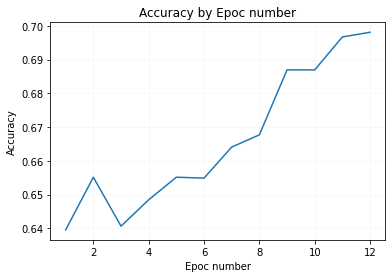

In [122]:
plt.title('Accuracy by Epoc number')
plt.xlabel('Epoc number')
plt.ylabel('Accuracy')
plt.plot([i for i in range(1,13)],acc_list[:12])
plt.grid(alpha=0.1)
plt.show()

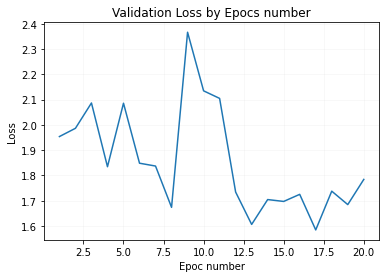

In [117]:
plt.title('Validation Loss by Epocs number')
plt.xlabel('Epoc number')
plt.ylabel('Loss')
plt.plot([i for i in range(1,21)],loss_list['val'])
# plt.plot([i for i in range(1,21)],loss_list['train'])
plt.grid(alpha=0.1)
plt.show()

# Model mistakes

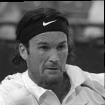

In [165]:
tr = transforms.ToPILImage()
tr(t[0])

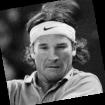

In [161]:
tr(t[1])

In [162]:
print(f'Model predicted {float(pic[0])} where actually the result is: {int(pic[1])}')

Model predicted 0.2881831228733063 where actually the result is: 1


In [180]:
model = SiameseNet()
model = torch.load('/content/drive/MyDrive/Deep_models/model_3_less_layers.txt')
model.eval()
t,pic,a,b = test(test_dataloader, model, loss_fn)


Test Error: 
 Accuracy: 63.7%, Avg loss: 0.653972 



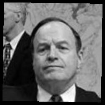

In [190]:
tr = transforms.ToPILImage()
tr(t[1][0])

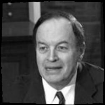

In [189]:
tr(t[1][1])

In [202]:
print(f'Model predicted {float(pic[5][0])} where actually the result is: {int(pic[5][1])}')

Model predicted 0.5653400421142578 where actually the result is: 1
